# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFlite_Version  = "1500"   
TFlite_MainType = "dig-class11"
TFlite_Size     = "s2"
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1468, 32, 20, 3)
(1468, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
inputs = tf.keras.Input(shape=(32, 20, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs3)
inputs5 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(256,activation="relu")(inputs9)
output = tf.keras.layers.Dense(11, activation='softmax')(inputs10)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

#model = Sequential()
#model.add(BatchNormalization(input_shape=(32,20,3)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(256,activation="relu"))
#model.add(Dense(11, activation = "softmax"))

#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

#model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 20, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 20, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 20, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 10, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 10, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 5, 32)         0     

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.2
Rotation_Angle = 5
ZoomRange = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
367/367 [==============================] - 4s 9ms/step - loss: 2.1359 - accuracy: 0.3426
Epoch 2/500
367/367 [==============================] - 3s 9ms/step - loss: 1.5533 - accuracy: 0.4986
Epoch 3/500
367/367 [==============================] - 3s 9ms/step - loss: 1.0390 - accuracy: 0.6730
Epoch 4/500
367/367 [==============================] - 3s 9ms/step - loss: 0.8281 - accuracy: 0.7432
Epoch 5/500
367/367 [==============================] - 3s 9ms/step - loss: 0.6536 - accuracy: 0.8052
Epoch 6/500
367/367 [==============================] - 3s 8ms/step - loss: 0.5749 - accuracy: 0.8304
Epoch 7/500
367/367 [==============================] - 3s 9ms/step - loss: 0.5498 - accuracy: 0.8508
Epoch 8/500
367/367 [==============================] - 3s 9ms/step - loss: 0.4925 - accuracy: 0.8563
Epoch 9/500
367/367 [==============================] - 3s 9ms/step - loss: 0.4553 - accuracy: 0.8706
Epoch 10/500
367/367 [==============================] - 3s 9ms/step - loss: 0.3919 - accura

367/367 [==============================] - 3s 9ms/step - loss: 0.0703 - accuracy: 0.9816
Epoch 82/500
367/367 [==============================] - 3s 9ms/step - loss: 0.1154 - accuracy: 0.9680
Epoch 83/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0876 - accuracy: 0.9734
Epoch 84/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0982 - accuracy: 0.9734
Epoch 85/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0622 - accuracy: 0.9857
Epoch 86/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0948 - accuracy: 0.9728
Epoch 87/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0969 - accuracy: 0.9728
Epoch 88/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0717 - accuracy: 0.9802
Epoch 89/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0817 - accuracy: 0.9823
Epoch 90/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0812 - accuracy: 

367/367 [==============================] - 3s 9ms/step - loss: 0.0746 - accuracy: 0.9830
Epoch 161/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0471 - accuracy: 0.9884
Epoch 162/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0782 - accuracy: 0.9850
Epoch 163/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0659 - accuracy: 0.9823
Epoch 164/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0466 - accuracy: 0.9830
Epoch 165/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0640 - accuracy: 0.9871
Epoch 166/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0446 - accuracy: 0.9911
Epoch 167/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0654 - accuracy: 0.9843
Epoch 168/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0811 - accuracy: 0.9823
Epoch 169/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0543 - a

367/367 [==============================] - 3s 8ms/step - loss: 0.0326 - accuracy: 0.9911
Epoch 240/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0281 - accuracy: 0.9918
Epoch 241/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0332 - accuracy: 0.9932
Epoch 242/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0239 - accuracy: 0.9905
Epoch 243/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0216 - accuracy: 0.9939
Epoch 244/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0525 - accuracy: 0.9891
Epoch 245/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0450 - accuracy: 0.9864
Epoch 246/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0242 - accuracy: 0.9918
Epoch 247/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0413 - accuracy: 0.9884
Epoch 248/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0479 - a

367/367 [==============================] - 3s 8ms/step - loss: 0.0497 - accuracy: 0.9884
Epoch 319/500
367/367 [==============================] - 3s 7ms/step - loss: 0.0420 - accuracy: 0.9925
Epoch 320/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0502 - accuracy: 0.9884
Epoch 321/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0404 - accuracy: 0.9918
Epoch 322/500
367/367 [==============================] - 3s 7ms/step - loss: 0.0287 - accuracy: 0.9939
Epoch 323/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0277 - accuracy: 0.9911
Epoch 324/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0363 - accuracy: 0.9925
Epoch 325/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0535 - accuracy: 0.9898
Epoch 326/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0337 - accuracy: 0.9898
Epoch 327/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0315 - a

367/367 [==============================] - 3s 7ms/step - loss: 0.0299 - accuracy: 0.9939
Epoch 398/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0175 - accuracy: 0.9939
Epoch 399/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0371 - accuracy: 0.9932
Epoch 400/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0453 - accuracy: 0.9932
Epoch 401/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0172 - accuracy: 0.9952
Epoch 402/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0546 - accuracy: 0.9911
Epoch 403/500
367/367 [==============================] - 3s 9ms/step - loss: 0.0444 - accuracy: 0.9877
Epoch 404/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0182 - accuracy: 0.9959
Epoch 405/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0236 - accuracy: 0.9918
Epoch 406/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0435 - a

367/367 [==============================] - 3s 8ms/step - loss: 0.0671 - accuracy: 0.9850
Epoch 477/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0157 - accuracy: 0.9946
Epoch 478/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0288 - accuracy: 0.9939
Epoch 479/500
367/367 [==============================] - 3s 7ms/step - loss: 0.0242 - accuracy: 0.9952
Epoch 480/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0433 - accuracy: 0.9925
Epoch 481/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0280 - accuracy: 0.9925
Epoch 482/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0219 - accuracy: 0.9939
Epoch 483/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0597 - accuracy: 0.9905
Epoch 484/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0200 - accuracy: 0.9911
Epoch 485/500
367/367 [==============================] - 3s 8ms/step - loss: 0.0147 - a

### Learing result
 
* Visualization of the training and validation results

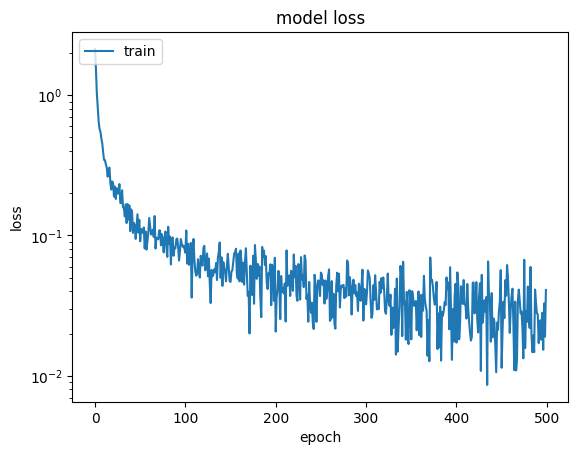

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\4_red2_19700109-012540.jpg 4 6


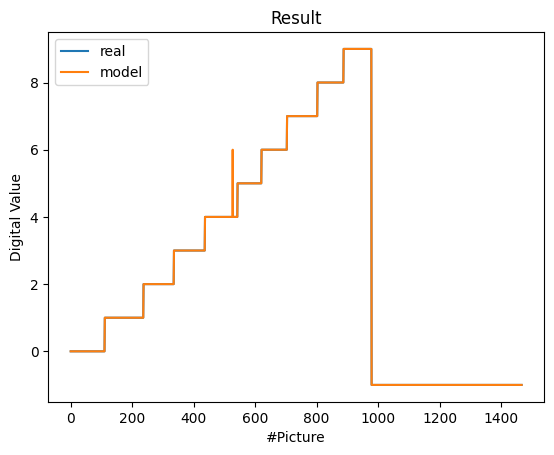

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img, verbose=0), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp4uog2j_s\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp4uog2j_s\assets


356488

In [8]:
FileName = TFlite_MainType + "_" + TFlite_Version + "_" + TFlite_Size + "_q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpllflax78\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpllflax78\assets
C:\Users\Muell\anaconda3\envs\py39-td-opencv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


dig-class11_1500_s2_q.tflite


96984

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.